## What is the Network Analysis?

The ArcGIS Network Analyst allows you to solve common `network` problems

Modern routing algorithm area varients of **Dijkstra's algorithm**

### Examples:

- finding the best route across a city
- finding the closest emergency vehicle or facility, 
- identifying a service area around a location
- servicing a set of orders with a fleet of vehicles 
- choosing the best facilities to open or close.



# Constructing drive time based service areas
This sample shows how the `network` module of the ArcGIS API for Python can be used to construct service areas. In this sample, we generate service areas for two of the fire stations in central Tokyo, Japan. We later observe how the service area varies by time of day for a fire station in the city of Los Angeles.

##### Connect to the GIS

In [1]:
from datetime import datetime
from IPython.display import HTML
import pandas as pd
from arcgis.gis import GIS

my_gis = GIS(profile='agol_profile')

<User username:AndrewSolutions>
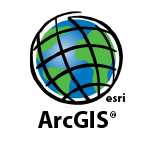

In [2]:
my_gis.users.me

In [3]:
from getpass import getpass

### Create a Network Layer

In [4]:
from arcgis.network import ServiceAreaLayer

In [5]:
service_area_url = my_gis.properties.helperServices.serviceArea.url
service_area_url

'https://route.arcgis.com/arcgis/rest/services/World/ServiceAreas/NAServer/ServiceArea_World'

In [6]:
sa_layer = ServiceAreaLayer(service_area_url, gis=my_gis)

## Calculate service area from Palm Springs Convention Center

In [7]:
from arcgis.geocoding import geocode
ps_geocode = geocode('Palm Springs Convention Center', as_featureset=True)
type(ps_geocode)

arcgis.features.feature.FeatureSet

# Display the Convetion Center

In [8]:
map1 = my_gis.map('Palm Springs, CA', zoomlevel=12)
map1

MapView(layout=Layout(height='400px', width='100%'), zoom=12.0)

In [9]:
map1.draw(ps_geocode)

## Compute the service area


In [10]:
travel_modes = sa_layer.retrieve_travel_modes()

for t in travel_modes['supportedTravelModes']:
    print(t['name'])

Walking Time
Rural Driving Distance
Driving Time
Driving Distance
Walking Distance
werewr
Trucking Time
Rural Driving Time


In [11]:
truck_mode = [t for t in travel_modes['supportedTravelModes'] if t['name'] == 'Driving Time'][0]

In [12]:
result = sa_layer.solve_service_area(ps_geocode, default_breaks=[5,10,15], 
                                     travel_direction='esriNATravelDirectionToFacility',
                                     travel_mode=truck_mode)

#### Read the result back as a `FeatureSet`
The `result` variable contains the service area as a dictionary. We inspect its keys and construct `Feature` and `FeatureSet` objects out of it to display in the map

In [14]:
result.keys()

dict_keys(['messages', 'saPolygons'])

In [15]:
result['saPolygons'].keys()

dict_keys(['fieldAliases', 'geometryType', 'spatialReference', 'features'])

In [16]:
from arcgis.features import FeatureSet
fs = FeatureSet.from_dict(result['saPolygons'])
from arcgis.features import Feature

In [18]:
poly_feat_list = []
for polygon_dict in result['saPolygons']['features']:
    f1 = Feature(polygon_dict['geometry'], polygon_dict['attributes'])
    poly_feat_list.append(f1)

In [19]:
service_area_fset = FeatureSet(poly_feat_list, 
                         geometry_type=result['saPolygons']['geometryType'],
                         spatial_reference= result['saPolygons']['spatialReference'])

### Visualize the service area on the map
From the DataFrame above, we know, there are 3 service area polygons for each fire station. The drive times are given as a range between `FromBreak` and `ToBreak` columns. Let us use this information to visualize the polygons with different colors and appropriate popup messags on the map

In [20]:
colors = {5: [0, 128, 0, 90], 
          10: [255, 255, 0, 90], 
          15: [255, 0, 0, 90]}

fill_symbol = {"type": "esriSFS","style": "esriSFSSolid",
               "color": [115,76,0,255]}

In [21]:
for service_area in service_area_fset.features:
    
    #set color based on drive time
    fill_symbol['color'] = colors[service_area.attributes['ToBreak']]
    
    #set popup
    popup={"title": "Service area", 
            "content": "{} minutes".format(service_area.attributes['ToBreak'])}
    
    map1.draw(service_area.geometry, symbol=fill_symbol, popup=popup)

Click the drive time areas to explore their attributes. Because the content of the pop-ups may include HTML source code, it is also possible to have the pop-up windows include other resources such as tables and images.

### Driving directions

In [22]:
from arcgis.network import RouteLayer

In [23]:
route_service_url = my_gis.properties.helperServices.route.url
route_service_url

'https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World'

In [24]:
route_service = RouteLayer(route_service_url, gis=my_gis)
route_service

<RouteLayer url:"https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World">

In [25]:
stops = ['White House', '2436 Rayburn Hob, Washington, DC 20515']
from arcgis.geocoding import geocode, batch_geocode
stops_geocoded = batch_geocode(stops)

#### data wrangling

In [26]:
stops_geocoded = [item['location'] for item in stops_geocoded]
stops_geocoded

[{'x': -77.03643005499998, 'y': 38.89792994800007},
 {'x': -77.01050999999995, 'y': 38.887050000000045}]

In [27]:
stops_geocoded2 = '{},{};{},{}'.format(stops_geocoded[0]['x'],stops_geocoded[0]['y'],
                                       stops_geocoded[1]['x'],stops_geocoded[1]['y'])
stops_geocoded2

'-77.03643005499998,38.89792994800007;-77.01050999999995,38.887050000000045'

### find dirving directions

In [28]:
result = route_service.solve(stops_geocoded2, 
                             return_routes=True,
                           return_stops=True, return_directions=True,
                           return_barriers=False, return_polygon_barriers=False,
                           return_polyline_barriers=False)

In [29]:
map2 = my_gis.map('White House', zoomlevel=13)
map2

MapView(layout=Layout(height='400px', width='100%'), zoom=13.0)

In [30]:
from arcgis.features import Feature, FeatureSet
features = result['routes']['features']
routes = FeatureSet(features)
stop_features = result['stops']['features']
stop_fset = FeatureSet(stop_features)
map2.draw(routes)
map2.draw(stop_fset)

In [31]:
len(result['stops'])

4

In [33]:
stop_features = result['stops']['features']
stop_fset = FeatureSet(stop_features)

In [34]:
symbol = {
    "type" : "simple-marker",
    "style" : "square",
    "outline" : {
        "style": "dash-dot"
    },
    "color": [255, 211, 127, 1]
}
map2.draw(stop_fset, symbol=symbol)

# Visualizing the Instructions

In [58]:
import pandas as pd
text = [att['attributes'] for att in result['directions'][0]['features']]
df = pd.DataFrame(text)[['text', 'length','time']]
df

,text,length,time
0,Start at Location 1,0.000000,0.000000
1,Go southeast,0.060442,0.583623
2,Turn left,0.049245,0.475513
3,Continue on Alexander Hamilton Pl NW,0.077650,0.659879
4,Turn right on 15th St NW,0.064152,0.497937
5,Turn left on Pennsylvania Ave NW,0.091244,0.762053
6,Turn right on 14th St NW,0.548412,2.533681
7,Turn left on Independence Ave SW,1.155949,4.727846
8,"Finish at Location 2, on the right",0.000000,0.000000
